https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

In [3]:
a = 2//40

print (a)

0


In [170]:
import numpy as np
def find_step(t, unit):
    """
    Find index we are at: 2^step?

    For example: if T = 350, M = 3, then unit = T/(2^0 + 2^1 + 2^2) = 50
    and t = 55 => we are at 2^1 space : step = 1

    Args:
        t: epoch(th)
        unit: unit value = T/(2^0 + 2^1 + .... + 2^(M-1))

    Returns: step of epoch(th)

    """
    step = 0
    previous_sum = 0
    for i in range(128):  # we suppose that index < 128 because 2^128 is a big number bro!
        previous_sum += unit * (2 ** i)
        if previous_sum > t:
            step = i
            break

    return step


def find_current_epoch_value(t, step, unit):
    """
    Find current epoch value based on which step we are at

    For example:
    t = 200, unit = 50, step = 2 (we are at 2^2 space)
    Then: current epoch value = 200 - 50*(2^0 + 2^1) = 100

    Args:
        t: epoch(th)
        step: step we are at!
        unit: unit value = T/(2^0 + 2^1 + .... + 2^(M-1))

    Returns:

    """
    previous_parts = 0
    for i in range(step):
        previous_parts += 2 ** i
    current = t - unit * previous_parts

    return current


class SnapshotCallbackBuilder:
    """Callback builder for snapshot ensemble training of a model.

    Creates a list of callbacks, which are provided when training a model
    so as to save the model weights at certain epochs, and then sharply
    increase the learning rate.
    """

    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        """
        Initialize a snapshot callback builder.

        # Arguments:
            nb_epochs: total number of epochs that the model will be trained for.
            nb_snapshots: number of times the weights of the model will be saved.
            init_lr: initial learning rate
        """
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model', is_super=True):
        """
        Creates a list of callbacks that can be used during training to create a
        snapshot ensemble of the model.

        Args:
            is_super: True if we want to use improved version of snapshot anneal schedule
            model_prefix: prefix for the filename of the weights.

        Returns: list of 3 callbacks [ModelCheckpoint, LearningRateScheduler,
                 SnapshotModelCheckpoint] which can be provided to the 'fit' function
        """
        if not os.path.exists('weights/'):
            os.makedirs('weights/')

        callback_list = [callbacks.ModelCheckpoint("weights/%s-Best.h5" % model_prefix, monitor="val_acc",
                                                   save_best_only=True, save_weights_only=True),
                         SnapshotModelCheckpoint(self.T, self.M, fn_prefix='weights/%s' % model_prefix)]

        if is_super:
            callback_list.append(callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule_super))
        else:
            callback_list.append(callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule))

        return callback_list

    def _cosine_anneal_schedule(self, t):
        """
        LearningRateScheduler with basic snapshot anneal schedule
        Args:
            t: epoch(th)

        Returns: learning rate value at epoch(th)

        """
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

    def _cosine_anneal_schedule_super(self, t):
        """
        LearningRateScheduler with improved snapshot anneal schedule
        Args:
            t: epoch(th)

        Returns: learning rate value at epoch(th)

        TODO: clean it up a bit (>_<)
        """

        parts = 0
        for i in range(self.M):
            parts += 2 ** i
        unit = self.T // parts

        step = find_step(t, unit)
        space = unit * (2 ** step)
        current = find_current_epoch_value(t, step, unit)

        cos_inner = np.pi * current  # t - 1 is used when t has 1-based indexing
        cos_inner /= space
        cos_out = np.cos(cos_inner) + 1

        return float(self.alpha_zero / 2 * cos_out)


## Let's initialize some values

In [173]:

nb_epochs = 350
nb_snapshots = 3

snap1 = SnapshotCallbackBuilder(350, 3, 0.1)
print ("snap1: ", snap1._cosine_anneal_schedule(349))

snap2 = SnapshotCallbackBuilder(nb_epochs, nb_snapshots, 0.1)

print ("snap_super: ", snap2._cosine_anneal_schedule_super(349))



snap1:  0.0999816643111642
snap_super:  6.168375916970615e-06


## Time to visualize the graph (>_<)


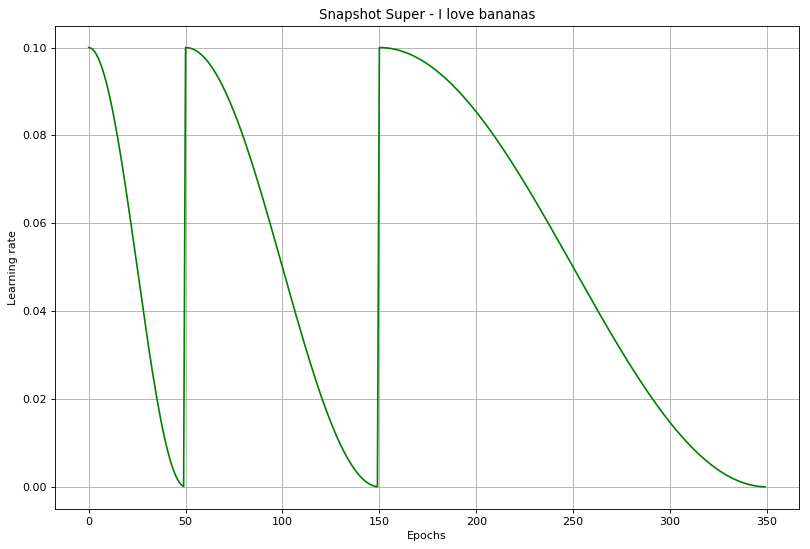

In [172]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

list_index =[]
list_snap = []
for i in range(nb_epochs):
    list_index.append(i)
    list_snap.append(snap2._cosine_anneal_schedule_super(i))
    



plt.plot(list_index, list_snap, 'k', color='green')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.title('Snapshot Super - I love bananas') # I love bananas though
plt.grid(True)
plt.show()